##### Copyright 2018 The TensorFlow Authors.

In [4]:
!python -m ipykernel install --user

Installed kernelspec python3 in C:\Users\Brian\AppData\Roaming\jupyter\kernels\python3


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Predict fuel efficiency

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto Energy](https://archive.ics.uci.edu/ml/datasets/auto+Energy) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## The Auto Energy dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download the dataset.

In [8]:
dataset_path = 'temp/main_output.csv'
dataset_path

'temp/main_output.csv'

In [72]:
dataset = pd.read_csv(dataset_path)
dataset.head()

,ID,Avg. Ht,Lat,Lon,Electricity,Natural Gas,Total Area,Total Elec Per Area,Total Elec
0,1,1.74,41.867863,-87.628662,259.35,45.13,285.41,908.69,259.35
1,2,2.17,41.867859,-87.629822,295.28,43.49,313.14,942.95,295.28
2,4,2.97,41.867859,-87.629822,303.20,41.07,251.16,1207.21,303.20
3,5,3.03,41.867863,-87.628662,330.35,41.22,288.21,1146.20,330.35
4,10,3.73,41.867870,-87.626404,354.79,40.52,282.49,1255.94,354.79


In [73]:
dataset['Energy'] = dataset['Electricity'] + dataset['Natural Gas']

In [74]:
# dataset = dataset.drop(columns=['ID', 'Total Elec Per Area', 'Total Elec', 'Total Area'])
dataset = dataset[['Avg. Ht','Lat','Lon','Energy']]

In [75]:
dataset.head(1)

,Avg. Ht,Lat,Lon,Energy
0,1.74,41.867863,-87.628662,304.48


### Clean the data

Check for unknown values.

In [76]:
dataset.isna().sum()

Avg. Ht    0
Lat        0
Lon        0
Energy     0
dtype: int64

In [10]:
# dataset = dataset.dropna()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [77]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

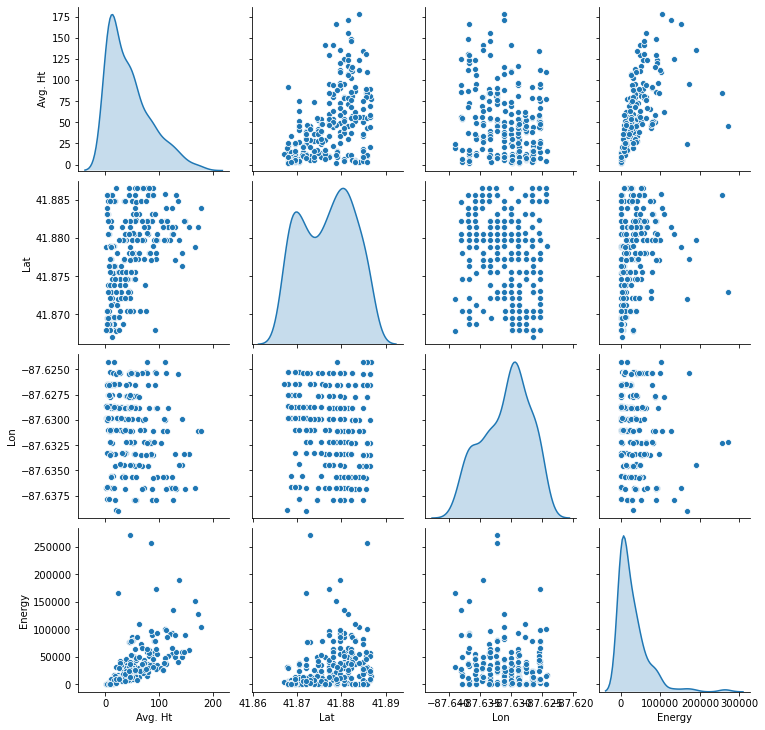

In [79]:
sns.pairplot(train_dataset[dataset.columns], diag_kind="kde")

Also look at the overall statistics:

In [80]:
train_stats = train_dataset.describe()
train_stats.pop("Energy")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Avg. Ht,261.0,45.018544,39.957261,1.740000,10.540000,35.930000,67.370000,177.850000
Lat,261.0,41.876847,0.005825,41.867023,41.871258,41.877193,41.881443,41.886570
Lon,261.0,-87.630710,0.003729,-87.638977,-87.633392,-87.629883,-87.627686,-87.624237


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [81]:
train_labels = train_dataset.pop('Energy')
test_labels = test_dataset.pop('Energy')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [82]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [83]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [84]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [86]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.15754558],
       [-0.10610928],
       [-0.02880524],
       [ 0.3407645 ],
       [-0.02730532],
       [-0.09113872],
       [ 0.5193948 ],
       [-0.3155384 ],
       [ 0.1084118 ],
       [-0.08709465]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [87]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:2532760832.0000,  mae:29750.7363,  mse:2532760832.0000,  val_loss:2044042752.0000,  val_mae:31273.0273,  val_mse:2044042752.0000,  
....................................................................................................
Epoch: 100, loss:2407705088.0000,  mae:28532.4199,  mse:2407705088.0000,  val_loss:1909512192.0000,  val_mae:29704.4082,  val_mse:1909512192.0000,  
....................................................................................................
Epoch: 200, loss:1797774848.0000,  mae:22824.5898,  mse:1797774848.0000,  val_loss:1297707648.0000,  val_mae:21768.0566,  val_mse:1297707648.0000,  
....................................................................................................
Epoch: 300, loss:1114842752.0000,  mae:17307.9941,  mse:1114842752.0000,  val_loss:804428608.0000,  val_mae:18589.1309,  val_mse:804428608.0000,  
....................................................................................................
Epo

Visualize the model's training progress using the stats stored in the `history` object.

In [88]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,932957632.0,15787.941406,932957632.0,597679808.0,17587.199219,597679808.0,995
996,933104000.0,15797.999023,933104000.0,597818176.0,17588.968750,597818176.0,996
997,933029312.0,15773.291992,933029312.0,597713728.0,17589.236328,597713728.0,997
998,932883136.0,15771.172852,932883136.0,597390336.0,17579.718750,597390336.0,998
999,933045312.0,15776.719727,933045312.0,597138560.0,17569.804688,597138560.0,999


In [89]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Energy]')

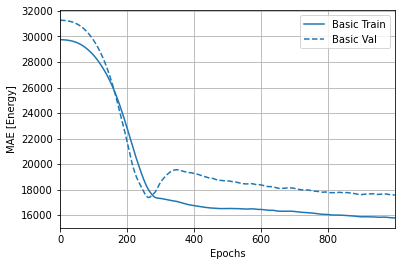

In [91]:
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 2000])
# plt.xlim([400, 1000])
plt.ylabel('MAE [Energy]')

Text(0, 0.5, 'MSE [Energy^2]')

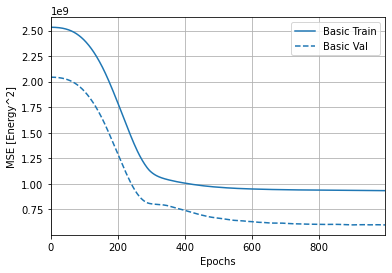

In [92]:
plotter.plot({'Basic': history}, metric = "mse")
# plt.ylim([0, 2000000])
# plt.xlim([400, 1000])
plt.ylabel('MSE [Energy^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

Text(0, 0.5, 'MAE [MPG]')

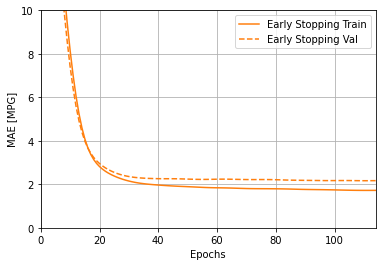

In [28]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [Energy]')

The graph shows that on the validation set, the average error is usually around +/- 2 Energy. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [29]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Energy".format(mae))

3/3 - 0s - loss: 5.4297 - mae: 1.8526 - mse: 5.4297
Testing set Mean Abs Error:  1.85 MPG


### Make predictions

Finally, predict Energy values using data in the testing set:

Text(0, 0.5, 'Predictions [Energy]')

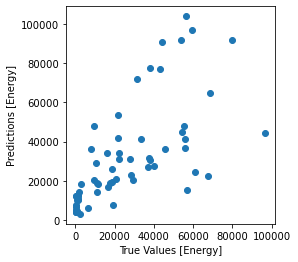

In [93]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Energy]')
plt.ylabel('Predictions [Energy]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)


It looks like our model predicts reasonably well. Let's take a look at the error distribution.

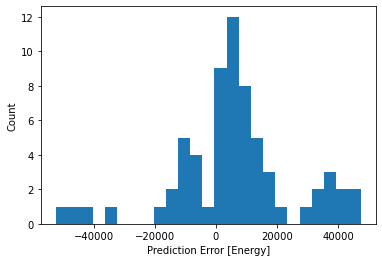

In [94]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Energy]")
_ = plt.ylabel("Count")

In [107]:
arr = np.array([34,12,14]).reshape(-1,3)

In [105]:
arr.reshape(-1, 3)

array([[34, 12, 14]])

In [109]:
dataset

,Avg. Ht,Lat,Lon,Energy
0,1.74,41.867863,-87.628662,304.48
1,2.17,41.867859,-87.629822,338.77
2,2.97,41.867859,-87.629822,344.27
3,3.03,41.867863,-87.628662,371.57
4,3.73,41.867870,-87.626404,395.31
...,...,...,...,...
321,77.78,41.886570,-87.624298,15126.86
322,20.63,41.886547,-87.625458,9121.99
323,44.16,41.886547,-87.625458,24879.17
324,68.68,41.887413,-87.624329,9571.82


In [110]:
train_dataset

,Avg. Ht,Lat,Lon
122,13.73,41.875465,-87.635590
66,44.19,41.870422,-87.626434
142,38.81,41.875507,-87.627625
245,148.39,41.882244,-87.636810
146,10.69,41.877193,-87.628784
...,...,...,...
148,46.80,41.877167,-87.634460
143,47.46,41.875526,-87.625336
180,88.59,41.878895,-87.631073
131,6.75,41.876369,-87.626495


In [108]:
model.predict(arr)

array([[915476.2]], dtype=float32)

It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.